#Logistic Regression 

###ROC curve, Odds ratio, Interpretation, Grad School and MIT MOOC data set

In [1]:
import pdb

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import sklearn.metrics as skm
import numpy as np
import pandas as pd
%matplotlib inline

## ROC Curve

Below is an implementation of the ROC curve function:

```
function ROC_curve(probabilities, labels):
    Sort instances by their prediction strength (the probabilities)
    For every instance in increasing order of probability:
        Set the threshold to be the probability
        Set everything above the threshold to the positive class
        Calculate the True Positive Rate (aka sensitivity or recall)
        Calculate the False Positive Rate (1 - specificity)
    Return three lists: TPRs, FPRs, thresholds
```

Recall that the *true positive rate* is

```
 number of true positives     number correctly predicted positive
-------------------------- = -------------------------------------
 number of positive cases           number of positive cases
```

and the *false positive rate* is

```
 number of false positives     number incorrectly predicted positive
--------------------------- = ---------------------------------------
  number of negative cases           number of negative cases
```


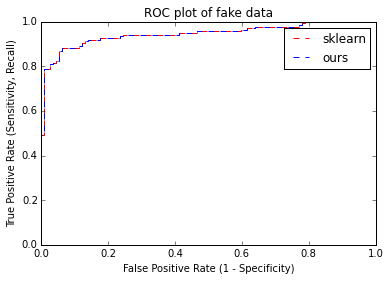

In [5]:
def roc_curve(probabilities, y_test):
    thresholds = np.sort(probabilities)
    TPRs = []
    FPRs = []
    no_of_positive_cases = y_test.sum()
    no_of_negative_cases = len(y_test) - no_of_positive_cases
    for t in thresholds:
        threshold = t
        predicted_y = (probabilities > threshold).astype(int)
        no_of_correctly_predicted_positive = ((predicted_y==y_test) & (y_test==1)).sum()
        TPR = no_of_correctly_predicted_positive/float(no_of_positive_cases)
        no_of_incorrectly_predicted_positive = predicted_y.sum() \
        - no_of_correctly_predicted_positive
        FPR = no_of_incorrectly_predicted_positive/float(no_of_negative_cases)
        TPRs.append(TPR)
        FPRs.append(FPR)
#         pdb.set_trace()
    return TPRs, FPRs, thresholds #[::-1]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=2, n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = skm.roc_curve(y_test, probabilities)
plt.plot(fpr, tpr, 'r--', label='sklearn')

tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr, 'b--', label='ours')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")
plt.legend()
plt.show()

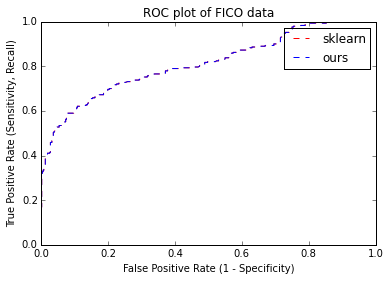

In [8]:
import pandas as pd
from sklearn.cross_validation import train_test_split

df = pd.read_csv('data/loanf.csv')
y = (df['Interest.Rate'] <= 12).values
X = df[['FICO.Score', 'Loan.Length', 'Loan.Amount']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = skm.roc_curve(y_test, probabilities)
plt.plot(fpr, tpr, 'r--', label='sklearn')

tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr, 'b--', label='ours')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of FICO data")
plt.legend()
plt.show()

##Grad School Admissions Dataset

The data we will be using is admission data on Grad school acceptances.

* `admit`: whether or not the applicant was admitted to grad. school
* `gpa`: undergraduate GPA
* `GRE`: score of GRE test
* `rank`: prestige of undergraduate school (1 is highest prestige, ala Harvard)

We will use the GPA, GRE, and rank of the applicants to try to predict whether or not they will be accepted into graduate school.

Before we get to predictions, we should do some data exploration.

In [10]:
df = pd.read_csv('data/grad.csv')
df.head()

admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4

In [11]:
df.describe()

admit         gre         gpa       rank
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000

In [12]:
admission_by_rank = pd.crosstab(df['admit'],df['rank'])
admission_by_rank

rank    1   2   3   4
admit                
0      28  97  93  55
1      33  54  28  12

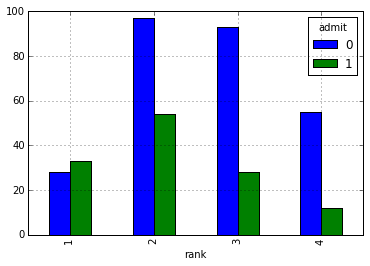

In [13]:
admission_by_rank.T.plot(kind='bar')
# looks like the rank (or prestige) of 
# a school that the applicant went to linearly correlates with acceptance numbers.

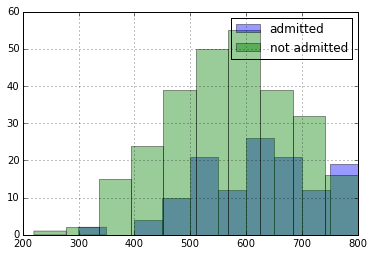

In [14]:
admit_by_gre = pd.crosstab(df['admit'], df['gre'])
admit_by_gre
df[df['admit'] == 1]['gre'].hist(alpha=0.4, label='admitted')
df[df['admit'] == 0]['gre'].hist(alpha=0.4, label='not admitted')
plt.legend()

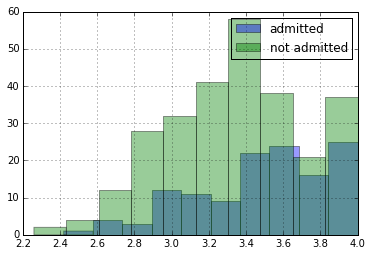

In [15]:
admit_by_gpa = pd.crosstab(df['admit'], pd.cut(df['gpa'], bins=10))
admit_by_gpa
df[df['admit'] == 1]['gpa'].hist(alpha=0.4, label='admitted')
df[df['admit'] == 0]['gpa'].hist(alpha=0.4, label='not admitted')
plt.legend()

The distributions of GPA and GRE look quite similar, normally distributed slightly skewed 
to the left (negative skew) centered around the means of GPA and GRE computed above. 
And for GPAs there is an anomolous bump near 4.0s

###Class Balance
Classes aren't too imbalanced so it should be fine. When dealing with data where the label
could potentially be something that is biased one way or the other (such as acceptance, fraud, signups, anything where one label is more dominant to the other or deals with some measure of "success"), it's important to check class balance.

In [73]:
df['admit'].describe()

count    400.000000
mean       0.317500
std        0.466087
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: admit, dtype: float64

31.7% admitted. So not too bad

# Predicting admissions

In [56]:
from statsmodels.discrete.discrete_model import Logit

y, X = df['admit'], df.drop('admit', axis=1)
X['ones'] = pd.Series(np.ones(df.shape[0]), index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

fit = Logit(y, X).fit()

fit.summary()
# p-values are all smaller than 0.05 so should be good

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Aug 2015   Pseudo R-squ.:                 0.08107
Time:                        16:37:02   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 8.207e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.101      0.036         0.000     0.004
gpa            0.7770      0.327      2.373      0.018         0.135     1.419
rank          -0.5600      0.127     -4.405      0.000        -0.809    -0.311
ones          -3.4495      1.133     -3.045      0.002        -5.670    -1.229
==============================================================================
"""

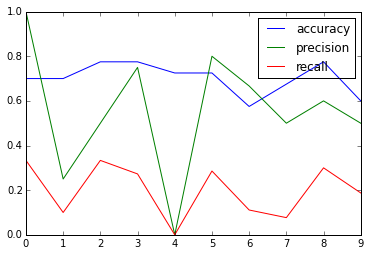

Accuracy: 0.7025
Precision: 0.556666666667
Recall: 0.200064241314


In [20]:
from sklearn.cross_validation import KFold

accuracy_scores = []
precision_scores = []
recall_scores = []

kf = KFold(n=X.shape[0], n_folds=10)

# pdb.set_trace()

for train_index, test_index in kf:
#     pdb.set_trace()
    X_train, X_test = X.ix[train_index,:], X.ix[test_index,:]
    y_train, y_test = y.ix[train_index], y.ix[test_index]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) #predict_proba(X_test)[:, 1]
    
    accuracy_scores.append(skm.accuracy_score(y_test, y_pred))
    precision_scores.append(skm.precision_score(y_test, y_pred))
    recall_scores.append(skm.recall_score(y_test, y_pred))
    
plt.plot(range(10), accuracy_scores, label='accuracy')
plt.plot(range(10), precision_scores, label='precision')
plt.plot(range(10), recall_scores, label='recall')
plt.legend()
plt.show()
print 'Accuracy: {}'.format(np.mean(accuracy_scores))
print 'Precision: {}'.format(np.mean(precision_scores))
print 'Recall: {}'.format(np.mean(recall_scores))

####Accuracy and precision pretty good. Recall is not.

####Since rank is numerical but with 4 buckets, we should consider it categorical and therefore binarize it

In [21]:
X_categorical = pd.get_dummies(X, columns=['rank'])

In [22]:
del X_categorical['rank_4']

In [24]:
X_categorical.head()

gre   gpa  ones  rank_1  rank_2  rank_3
0  380  3.61     1       0       0       1
1  660  3.67     1       0       0       1
2  800  4.00     1       1       0       0
3  640  3.19     1       0       0       0
4  520  2.93     1       0       0       0

Accuracy: 0.7
Precision: 0.515
Recall: 0.160076867577


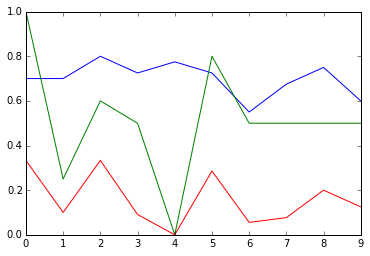

In [25]:
accuracy_scores = []
precision_scores = []
recall_scores = []

kf = KFold(n=X.shape[0], n_folds=10)

# pdb.set_trace()

for train_index, test_index in kf:
#     pdb.set_trace()
    X_train, X_test = X_categorical.ix[train_index,:], X_categorical.ix[test_index,:]
    y_train, y_test = y.ix[train_index], y.ix[test_index]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) #predict_proba(X_test)[:, 1]
    
    accuracy_scores.append(skm.accuracy_score(y_test, y_pred))
    precision_scores.append(skm.precision_score(y_test, y_pred))
    recall_scores.append(skm.recall_score(y_test, y_pred))
    
plt.plot(range(10), accuracy_scores, range(10), precision_scores, range(10), recall_scores)
print 'Accuracy: {}'.format(np.mean(accuracy_scores))
print 'Precision: {}'.format(np.mean(precision_scores))
print 'Recall: {}'.format(np.mean(recall_scores))

After binarization, it looks worse!

###ROC of logistic regression classifier

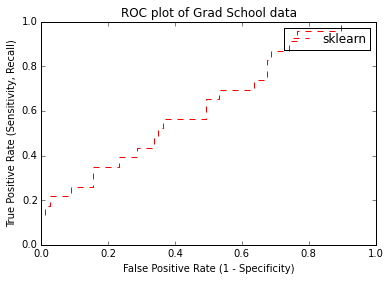

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = skm.roc_curve(y_test, probabilities)
plt.plot(fpr, tpr, 'r--', label='sklearn')

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of Grad School data")
plt.legend()
plt.show()

Based on the ROC curve, we want to pick a threshold where TPR > 60% and FPR < 40%.

In [149]:
print thresholds[ (fpr<.4) & (tpr>.6) ]
print 'mean: {}'.format(thresholds[ (fpr<.4) & (tpr>.6) ].mean())

[ 0.33319059  0.3305472   0.31585188  0.31505544  0.30647914  0.30098989]
mean: 0.317019023109


We will suggest a threshold around .31 because this gives us a FPR<.4 and a TPR>.6

####If we're using the classifier as a first step in the application process. We want to weed out clearly unqualified candidates, but not reject too many candidates. So we'd want to maximize the TPR and don't care as much about the FPR. With a threshold of 0.222, we can get a TPR of 96.9%. THe FPR will be 73.5%, but we are okay with this sacrifice in order to avoid false negatives.

##Interpreting the Odds Ratio

In [57]:
X_5 = X.drop('ones', axis=1)

In [58]:
model = LogisticRegression()
model.fit(X_5,y)
model.coef_

array([[ 0.00191577,  0.21564289, -0.59842009]])

In [59]:
import math
print math.exp(0.00203746) #gre
print math.exp(0.43741321) #gpa
print math.exp(-0.58644146) #rank

1.00203953703
1.54869588149
0.556303394498


Increasing the GRE by 1 point increases the odds of admission by a factor of 1.000, compared to other people with similar GPA and undergrad university rank.

Increasing the GPA by 1 point increases the odds of admission by a factor of 1.549, compared to other people with similar GPA and undergrad university rank.

Increasing the university rank by 1 point changes the odds of admission by a factor of 0.55, compared to other people with similar GPA and GRE. (This makes sense because higher rank number indicates a worse school).

In [191]:
#To double the probability...

print math.log(2)/0.00203746 #gre
print math.log(2)/0.43741321 #gpa
print math.log(2)/-0.58644146 #rank

340.201614049
1.5846507712
-1.18195459878


Increasing GRE by 340 points.
Increasing GPA by 1.58 points.
Improving the rank by 1.18 points.

####Now let's verify the odds ratio

In [60]:
gre = df['gre'].mean()
gpa = df['gpa'].mean()
feature_matrix = []
ranks = [1, 2, 3, 4]
for rank in ranks:
    feature_matrix.append([gre, gpa, rank])
X_rank = np.array(feature_matrix)

In [61]:
probabilities_rank = model.predict_proba(X_rank)[:, 1]
for rank, prob in zip(ranks, probabilities_rank):
    print "rank: %d, probability: %f, odds: %f" % (rank, prob, prob / (1 - prob))

rank: 1, probability: 0.517495, odds: 1.072519
rank: 2, probability: 0.370888, odds: 0.589541
rank: 3, probability: 0.244747, odds: 0.324059
rank: 4, probability: 0.151196, odds: 0.178128


In [69]:
print 'Increasing rank from 4 to 3, changes the odds of admission by a factor of %f compared to \
other people with similar GPA and GRE. (This makes sense because higher rank number indicates \
a worse school)' % float(0.175247 / 0.321042)

Increasing rank from 4 to 3, changes the odds of admission by a factor of 0.545869 compared to other people with similar GPA and GRE. (This makes sense because higher rank number indicates a worse school)


####The result is exactly the same as above

###Rank vs. probability of acceptance

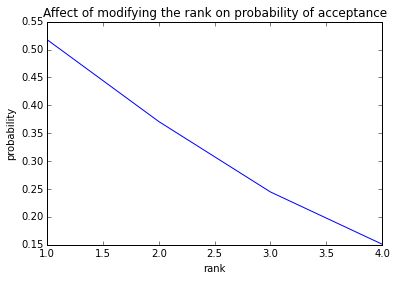

In [70]:
plt.plot(ranks, probabilities_rank)
plt.xlabel("rank")
plt.ylabel("probability")
plt.title("Affect of modifying the rank on probability of acceptance")
plt.show()

###Rank vs. odds of acceptance

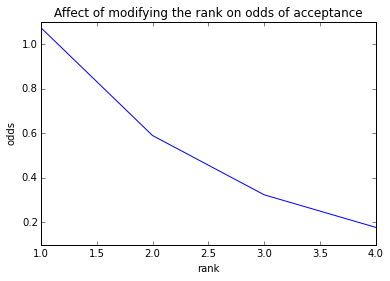

In [71]:
odds_rank = probabilities_rank / (1 - probabilities_rank)
plt.plot(ranks, odds_rank)
plt.xlabel("rank")
plt.ylabel("odds")
plt.title("Affect of modifying the rank on odds of acceptance")
plt.show()

###Rank vs. log odds of acceptance (can then see linear relationship)

####The slope is the beta coefficient!

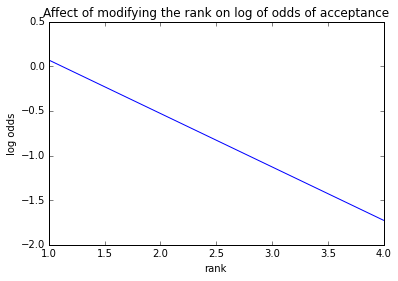

In [72]:
plt.plot(ranks, np.log(odds_rank))
plt.xlabel("rank")
plt.ylabel("log odds")
plt.title("Affect of modifying the rank on log of odds of acceptance")
plt.show()

##Same odds/probabilities analysis for GRE and GPA scores

In [74]:
gpa = df['gpa'].mean()
rank = df['rank'].mean()
feature_matrix = []
gres = range(df['gre'].min(), df['gre'].max() + 1)
for gre in gres:
    feature_matrix.append([gre, gpa, rank])
X_gre = np.array(feature_matrix)

probabilities_gre = model.predict_proba(X_gre)[:, 1]
for gre, prob in zip(gres, probabilities_gre):
    print "gre: %d, probability: %f, odds: %f" % (gre, prob, prob / (1 - prob))

gre: 220, probability: 0.179009, odds: 0.218041
gre: 221, probability: 0.179291, odds: 0.218459
gre: 222, probability: 0.179573, odds: 0.218878
gre: 223, probability: 0.179855, odds: 0.219297
gre: 224, probability: 0.180138, odds: 0.219718
gre: 225, probability: 0.180421, odds: 0.220139
gre: 226, probability: 0.180705, odds: 0.220561
gre: 227, probability: 0.180989, odds: 0.220984
gre: 228, probability: 0.181273, odds: 0.221408
gre: 229, probability: 0.181557, odds: 0.221833
gre: 230, probability: 0.181842, odds: 0.222258
gre: 231, probability: 0.182127, odds: 0.222684
gre: 232, probability: 0.182413, odds: 0.223111
gre: 233, probability: 0.182699, odds: 0.223539
gre: 234, probability: 0.182985, odds: 0.223968
gre: 235, probability: 0.183272, odds: 0.224397
gre: 236, probability: 0.183558, odds: 0.224827
gre: 237, probability: 0.183846, odds: 0.225259
gre: 238, probability: 0.184133, odds: 0.225691
gre: 239, probability: 0.184421, odds: 0.226123
gre: 240, probability: 0.184710, odds: 0

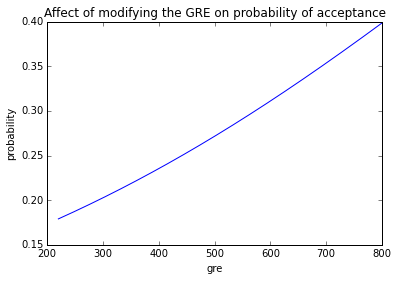

In [75]:
plt.plot(gres, probabilities_gre)
plt.xlabel("gre")
plt.ylabel("probability")
plt.title("Affect of modifying the GRE on probability of acceptance")
plt.show()

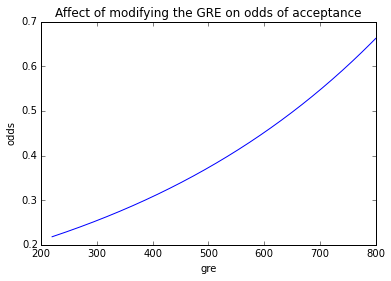

In [76]:
odds_gre = probabilities_gre / (1 - probabilities_gre)
plt.plot(gres, odds_gre)
plt.xlabel("gre")
plt.ylabel("odds")
plt.title("Affect of modifying the GRE on odds of acceptance")
plt.show()

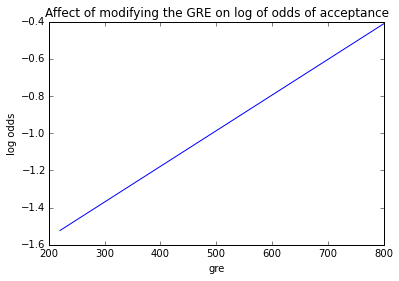

In [77]:
plt.plot(gres, np.log(odds_gre))
plt.xlabel("gre")
plt.ylabel("log odds")
plt.title("Affect of modifying the GRE on log of odds of acceptance")
plt.show()

In [79]:
gre = df['gre'].mean()
rank = df['rank'].mean()
feature_matrix = []
gpas = range(int(np.floor(df['gpa'].min())), int(np.ceil(df['gpa'].max() + 1)))
for gpa in gpas:
    feature_matrix.append([gre, gpa, rank])
X_gpa = np.array(feature_matrix)

probabilities_gpa = model.predict_proba(X_gpa)[:, 1]
for gpa, prob in zip(gpas, probabilities_gpa):
    print "gpa: %d, probability: %f, odds: %f" % (gpa, prob, prob / (1 - prob))

gpa: 2, probability: 0.246314, odds: 0.326813
gpa: 3, probability: 0.288491, odds: 0.405464
gpa: 4, probability: 0.334683, odds: 0.503043


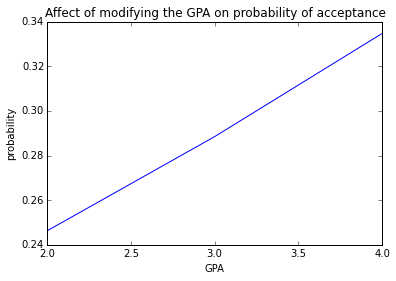

In [80]:
plt.plot(gpas, probabilities_gpa)
plt.xlabel("GPA")
plt.ylabel("probability")
plt.title("Affect of modifying the GPA on probability of acceptance")
plt.show()

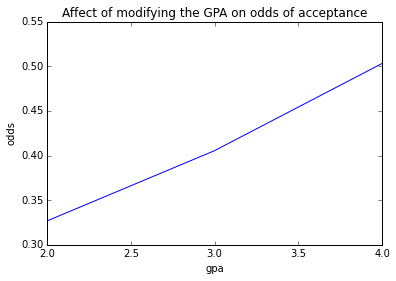

In [81]:
odds_gpa = probabilities_gpa / (1 - probabilities_gpa)
plt.plot(gpas, odds_gpa)
plt.xlabel("gpa")
plt.ylabel("odds")
plt.title("Affect of modifying the GPA on odds of acceptance")
plt.show()

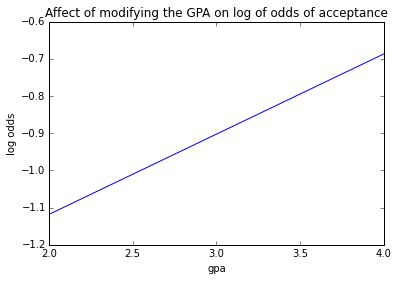

In [82]:
plt.plot(gpas, np.log(odds_gpa))
plt.xlabel("gpa")
plt.ylabel("log odds")
plt.title("Affect of modifying the GPA on log of odds of acceptance")
plt.show()

##Harvard and MIT MOOC dataset!

Harvard and MIT have [released](http://newsoffice.mit.edu/2014/mit-and-harvard-release-de-identified-learning-data-open-online-courses) a great dataset around engagement statistics for their MOOC courses. The data is in `data/mooc.csv` and a description of the dataset can be found in `data/mooc.pdf`.

One of the biggest issues with MOOCs is engagement. We will try to predict the probability of 'engagement' of a student given all the other columns.  We will define engagement here as either: `explored == 1 OR certified == 1`.

###EDA

In [151]:
df_mooc = pd.read_csv('data/mooc.csv')

In [4]:
df_mooc.head()

course_id       userid_DI  registered  viewed  explored  \
0  HarvardX/CB22x/2013_Spring  MHxPC130442623           1       0         0   
1         HarvardX/CS50x/2012  MHxPC130442623           1       1         0   
2  HarvardX/CB22x/2013_Spring  MHxPC130275857           1       0         0   
3         HarvardX/CS50x/2012  MHxPC130275857           1       0         0   
4  HarvardX/ER22x/2013_Spring  MHxPC130275857           1       0         0   

   certified final_cc_cname_DI LoE_DI  YoB gender grade start_time_DI  \
0          0     United States    NaN  NaN    NaN     0    2012-12-19   
1          0     United States    NaN  NaN    NaN     0    2012-10-15   
2          0     United States    NaN  NaN    NaN     0    2013-02-08   
3          0     United States    NaN  NaN    NaN     0    2012-09-17   
4          0     United States    NaN  NaN    NaN     0    2012-12-19   

  last_event_DI  nevents  ndays_act  nplay_video  nchapters  nforum_posts  \
0    2013-11-17      NaN          9          NaN        NaN             0   
1           NaN      NaN          9          NaN          1             0   
2    2013-11-17      NaN         16          NaN        NaN             0   
3           NaN      NaN         16          NaN        NaN             0   
4           NaN      NaN         16          NaN        NaN             0   

   roles  incomplete_flag  
0    NaN                1  
1    NaN                1  
2    NaN                1  
3    NaN                1  
4    NaN                1

In [152]:
df_mooc['engaged'] = (df_mooc.explored == 1) | (df_mooc.certified == 1)

In [6]:
df_mooc.engaged.describe() 

count        641138
mean     0.06297552
std       0.2429191
min           False
25%               0
50%               0
75%               0
max            True
Name: engaged, dtype: object

####Only 6% is engaged, class imbalance here

####Engagement by classes

In [7]:
df_mooc.groupby('course_id')['engaged'].mean()

course_id
HarvardX/CB22x/2013_Spring     0.018299
HarvardX/CS50x/2012            0.065016
HarvardX/ER22x/2013_Spring     0.069435
HarvardX/PH207x/2012_Fall      0.104179
HarvardX/PH278x/2013_Spring    0.031867
MITx/14.73x/2013_Spring        0.105633
MITx/2.01x/2013_Spring         0.099029
MITx/3.091x/2012_Fall          0.063032
MITx/3.091x/2013_Spring        0.028506
MITx/6.002x/2012_Fall          0.074343
MITx/6.002x/2013_Spring        0.041511
MITx/6.00x/2012_Fall           0.063074
MITx/6.00x/2013_Spring         0.046695
MITx/7.00x/2013_Spring         0.074825
MITx/8.02x/2013_Spring         0.058071
MITx/8.MReV/2013_Summer        0.042841
Name: engaged, dtype: float64

In [8]:
df_mooc.dtypes

course_id             object
userid_DI             object
registered             int64
viewed                 int64
explored               int64
certified              int64
final_cc_cname_DI     object
LoE_DI                object
YoB                  float64
gender                object
grade                 object
start_time_DI         object
last_event_DI         object
nevents              float64
ndays_act            float64
nplay_video          float64
nchapters            float64
nforum_posts           int64
roles                float64
incomplete_flag      float64
engaged                 bool
dtype: object

###Case 1: Dropping all of the n* variables (Better Model)

In [125]:
# Exclude features that we will not have before a student has completed a course
# List: grade, viewed, explored, certified, last_event_DI, (nevents), (ndays_act), 
# (nplay_video), (nchapters), (nforum_posts)

#dropping even more
df_mooc_reduced = df_mooc.drop(['grade', 'viewed', 'explored', 'certified', 'last_event_DI',
                               'nevents', 'ndays_act', 'nplay_video', 'nchapters', 
                                'nforum_posts', 'incomplete_flag', 'roles'], axis=1)

# df_mooc_reduced = df_mooc.drop(['grade', 'viewed', 'explored', 'certified'], axis=1)

In [126]:
df_mooc_reduced.dtypes

course_id             object
userid_DI             object
registered             int64
final_cc_cname_DI     object
LoE_DI                object
YoB                  float64
gender                object
start_time_DI         object
engaged                 bool
dtype: object

In [127]:
from datetime import datetime
df_mooc_reduced['start_time_DI'] = df_mooc_reduced['start_time_DI'].apply(\
    lambda x: (datetime.strptime(x, "%Y-%m-%d") - datetime(1970,1,1)).total_seconds())

In [129]:
#dropping even more
df_mooc_reduced[['YoB']] = df_mooc_reduced[['YoB']].fillna(0.0)


# df_mooc_reduced[['nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
#                 'incomplete_flag', 'YoB']] = \
# df_mooc_reduced[['nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
#                 'incomplete_flag', 'YoB']].fillna(0.0)

# df_mooc_reduced[['nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
#                 'incomplete_flag', 'YoB']] = \
# df_mooc_reduced[['nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
#                 'incomplete_flag', 'YoB']].fillna(0.0)

# df_mooc_reduced[['nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
#                 'incomplete_flag']] = \
# df_mooc_reduced[['nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
#                 'incomplete_flag']].fillna(0.0)

In [130]:
df_mooc_reduced.head()

course_id       userid_DI  registered final_cc_cname_DI  \
0  HarvardX/CB22x/2013_Spring  MHxPC130442623           1     United States   
1         HarvardX/CS50x/2012  MHxPC130442623           1     United States   
2  HarvardX/CB22x/2013_Spring  MHxPC130275857           1     United States   
3         HarvardX/CS50x/2012  MHxPC130275857           1     United States   
4  HarvardX/ER22x/2013_Spring  MHxPC130275857           1     United States   

  LoE_DI  YoB gender  start_time_DI engaged  
0    NaN    0    NaN     1355875200   False  
1    NaN    0    NaN     1350259200   False  
2    NaN    0    NaN     1360281600   False  
3    NaN    0    NaN     1347840000   False  
4    NaN    0    NaN     1355875200   False

####Binarize features

In [132]:
#dropping more
df_mooc_binarized = pd.concat([df_mooc_reduced.drop(['course_id', 'userid_DI', 'final_cc_cname_DI', 'LoE_DI',
                                'gender'], axis=1), 
           pd.get_dummies(df_mooc.course_id), pd.get_dummies(df_mooc.final_cc_cname_DI),
           pd.get_dummies(df_mooc.LoE_DI), pd.get_dummies(df_mooc.gender)], axis=1)

# df_mooc_binarized = pd.concat([df_mooc_reduced.drop(['course_id', 'userid_DI', 'final_cc_cname_DI', 'LoE_DI',
#                                 'gender', 'last_event_DI', 'roles'], axis=1), 
#            pd.get_dummies(df_mooc.course_id), pd.get_dummies(df_mooc.final_cc_cname_DI),
#            pd.get_dummies(df_mooc.LoE_DI), pd.get_dummies(df_mooc.gender)], axis=1)

# df_mooc_binarized = pd.concat([df_mooc_reduced.drop(['course_id', 'userid_DI', 'final_cc_cname_DI', 'LoE_DI',
#                                 'gender', 'last_event_DI', 'roles', 'YoB'], axis=1), 
#            pd.get_dummies(df_mooc.course_id), pd.get_dummies(df_mooc.final_cc_cname_DI),
#            pd.get_dummies(df_mooc.LoE_DI), pd.get_dummies(df_mooc.gender),
#            pd.get_dummies(df_mooc.YoB)], axis=1)

In [133]:
df_mooc_binarized.head()

registered  YoB  start_time_DI engaged  HarvardX/CB22x/2013_Spring  \
0           1    0     1355875200   False                           1   
1           1    0     1350259200   False                           0   
2           1    0     1360281600   False                           1   
3           1    0     1347840000   False                           0   
4           1    0     1355875200   False                           0   

   HarvardX/CS50x/2012  HarvardX/ER22x/2013_Spring  HarvardX/PH207x/2012_Fall  \
0                    0                           0                          0   
1                    1                           0                          0   
2                    0                           0                          0   
3                    1                           0                          0   
4                    0                           1                          0   

   HarvardX/PH278x/2013_Spring  MITx/14.73x/2013_Spring ...  United States  \
0                            0                        0 ...              1   
1                            0                        0 ...              1   
2                            0                        0 ...              1   
3                            0                        0 ...              1   
4                            0                        0 ...              1   

   Unknown/Other  Bachelor's  Doctorate  Less than Secondary  Master's  \
0              0           0          0                    0         0   
1              0           0          0                    0         0   
2              0           0          0                    0         0   
3              0           0          0                    0         0   
4              0           0          0                    0         0   

   Secondary  f  m  o  
0          0  0  0  0  
1          0  0  0  0  
2          0  0  0  0  
3          0  0  0  0  
4          0  0  0  0  

[5 rows x 62 columns]

In [134]:
df_mooc_binarized.dtypes

registered                       int64
YoB                            float64
start_time_DI                  float64
engaged                           bool
HarvardX/CB22x/2013_Spring     float64
HarvardX/CS50x/2012            float64
HarvardX/ER22x/2013_Spring     float64
HarvardX/PH207x/2012_Fall      float64
HarvardX/PH278x/2013_Spring    float64
MITx/14.73x/2013_Spring        float64
MITx/2.01x/2013_Spring         float64
MITx/3.091x/2012_Fall          float64
MITx/3.091x/2013_Spring        float64
MITx/6.002x/2012_Fall          float64
MITx/6.002x/2013_Spring        float64
...
Portugal               float64
Russian Federation     float64
Spain                  float64
Ukraine                float64
United Kingdom         float64
United States          float64
Unknown/Other          float64
Bachelor's             float64
Doctorate              float64
Less than Secondary    float64
Master's               float64
Secondary              float64
f                      float64
m       

In [135]:
target = df_mooc_binarized['engaged']
features = df_mooc_binarized.drop(['engaged'], axis=1)

In [136]:
target = target.apply(lambda x: int(x))

In [137]:
features.isnull().values.sum()

0

In [138]:
features.shape

(641138, 61)

In [139]:
from statsmodels.discrete.discrete_model import Logit

In [111]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [140]:
fit = Logit(target, features).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.221417
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                engaged   No. Observations:               641138
Model:                          Logit   Df Residuals:                   641120
Method:                           MLE   Df Model:                           17
Date:                Sun, 30 Aug 2015   Pseudo R-squ.:                 0.05811
Time:                        18:53:07   Log-Likelihood:            -1.4196e+05
converged:                       True   LL-Null:                   -1.5072e+05
                                        LLR p-value:                     0.000
==========================================================================================================
                                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------
registered                                28.7770   1.13e+05      0.000      1.000     -2.22e+05  2.22e+05
YoB                                       -0.0002   2.37e-05     -7.771      0.000        -0.000    -0.000
start_time_DI                          -2.501e-08   8.35e-10    -29.962      0.000     -2.67e-08 -2.34e-08
HarvardX/CB22x/2013_Spring                 0.8036   2.25e+05   3.57e-06      1.000     -4.42e+05  4.42e+05
HarvardX/CS50x/2012                        2.1772   2.25e+05   9.66e-06      1.000     -4.42e+05  4.42e+05
HarvardX/ER22x/2013_Spring                 2.2691   2.25e+05   1.01e-05      1.000     -4.42e+05  4.42e+05
HarvardX/PH207x/2012_Fall                  2.3409   2.25e+05   1.04e-05      1.000     -4.42e+05  4.42e+05
HarvardX/PH278x/2013_Spring                1.4494   2.25e+05   6.43e-06      1.000     -4.42e+05  4.42e+05
MITx/14.73x/2013_Spring                    2.6233   2.25e+05   1.16e-05      1.000     -4.42e+05  4.42e+05
MITx/2.01x/2013_Spring                     2.4356   2.25e+05   1.08e-05      1.000     -4.42e+05  4.42e+05
MITx/3.091x/2012_Fall                      1.6419   2.25e+05   7.29e-06      1.000     -4.42e+05  4.42e+05
MITx/3.091x/2013_Spring                    1.1315   2.25e+05   5.02e-06      1.000     -4.42e+05  4.42e+05
MITx/6.002x/2012_Fall                      1.8334   2.25e+05   8.14e-06      1.000     -4.42e+05  4.42e+05
MITx/6.002x/2013_Spring                    1.5031   2.25e+05   6.67e-06      1.000     -4.42e+05  4.42e+05
MITx/6.00x/2012_Fall                       1.6241   2.25e+05   7.21e-06      1.000     -4.42e+05  4.42e+05
MITx/6.00x/2013_Spring                     1.6914   2.25e+05   7.51e-06      1.000     -4.42e+05  4.42e+05
MITx/7.00x/2013_Spring                     2.2104   2.25e+05   9.81e-06      1.000     -4.42e+05  4.42e+05
MITx/8.02x/2013_Spring                     1.7849   2.25e+05   7.92e-06      1.000     -4.42e+05  4.42e+05
MITx/8.MReV/2013_Summer                    1.7518   2.25e+05   7.77e-06      1.000     -4.42e+05  4.42e+05
Australia                                  0.8282   2.12e+05   3.92e-06      1.000     -4.15e+05  4.15e+05
Bangladesh                                 0.4624   2.12e+05   2.19e-06      1.000     -4.15e+05  4.15e+05
Brazil                                     0.7124   2.12e+05   3.37e-06      1.000     -4.15e+05  4.15e+05
Canada                                     0.8700   2.12e+05   4.11e-06      1.000     -4.15e+05  4.15e+05
China                                      0.3202   2.12e+05   1.51e-06      1.000     -4.15e+05  4.15e+05
Colombia                                   1.0598   2.12e+05   5.01e-06      1.000     -4.15e+05  4.15e+05
Egypt                                      0.4358   2.12e+05   2.06e-06      1.000     -4.15e+05  4.15e+05
France                                     1.1556   2.12e+05   5.46e-06      1.000     -4.15e+05  4.15e+05
Germany                        

###Feature importance

The important features (p-val < 0.05) are having YoB, start_time, degree type and gender.

####Need to oversample because class is too imbalance

In [144]:
model = LogisticRegression(class_weight='auto')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

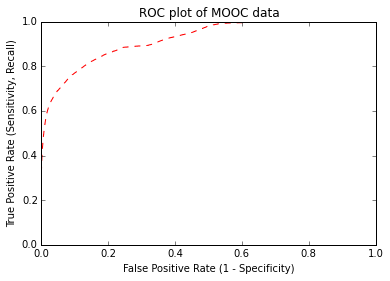

In [145]:
fpr, tpr, thresholds = skm.roc_curve(y_test, probabilities)
plt.plot(fpr, tpr, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of MOOC data")
plt.show()

In [146]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, model.predict(X_test))

array([[171400,   8873],
       [  3742,   8327]])

In [147]:
from sklearn.metrics import classification_report

In [148]:
print classification_report(y_test, model.predict(X_test))

             precision    recall  f1-score   support

          0       0.98      0.95      0.96    180273
          1       0.48      0.69      0.57     12069

avg / total       0.95      0.93      0.94    192342



###Case 2: Dropping some of n* variables

In [153]:
df_mooc_reduced = df_mooc.drop(['grade', 'viewed', 'explored', 'certified'], axis=1)
df_mooc_reduced['start_time_DI'] = df_mooc_reduced['start_time_DI'].apply(\
    lambda x: (datetime.strptime(x, "%Y-%m-%d") - datetime(1970,1,1)).total_seconds())
df_mooc_reduced[['nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
                'incomplete_flag', 'YoB']] = \
df_mooc_reduced[['nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts',
                'incomplete_flag', 'YoB']].fillna(0.0)
df_mooc_binarized = pd.concat([df_mooc_reduced.drop(['course_id', 'userid_DI', 'final_cc_cname_DI', 'LoE_DI',
                                'gender', 'last_event_DI', 'roles'], axis=1), 
           pd.get_dummies(df_mooc.course_id), pd.get_dummies(df_mooc.final_cc_cname_DI),
           pd.get_dummies(df_mooc.LoE_DI), pd.get_dummies(df_mooc.gender)], axis=1)
target = df_mooc_binarized['engaged']
features = df_mooc_binarized.drop(['engaged'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [154]:
fit = Logit(target, features).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.021618
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                engaged   No. Observations:               641138
Model:                          Logit   Df Residuals:                   641114
Method:                           MLE   Df Model:                           23
Date:                Sun, 30 Aug 2015   Pseudo R-squ.:                  0.9080
Time:                        19:05:09   Log-Likelihood:                -13860.
converged:                       True   LL-Null:                   -1.5072e+05
                                        LLR p-value:                     0.000
==========================================================================================================
                                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------
registered                                14.7564        nan        nan        nan           nan       nan
YoB                                     1.646e-05   7.53e-05      0.218      0.827        -0.000     0.000
start_time_DI                          -2.266e-08   2.67e-09     -8.495      0.000     -2.79e-08 -1.74e-08
nevents                                    0.0003   2.13e-05     13.192      0.000         0.000     0.000
ndays_act                                  0.0171      0.002      8.214      0.000         0.013     0.021
nplay_video                               -0.0006   7.55e-05     -8.057      0.000        -0.001    -0.000
nchapters                                  1.3604      0.010    132.467      0.000         1.340     1.381
nforum_posts                              -0.1940      0.048     -4.035      0.000        -0.288    -0.100
incomplete_flag                           -0.5869      0.063     -9.377      0.000        -0.710    -0.464
HarvardX/CB22x/2013_Spring                -3.7177   3.75e+05   -9.9e-06      1.000     -7.36e+05  7.36e+05
HarvardX/CS50x/2012                        7.3228   3.75e+05   1.95e-05      1.000     -7.36e+05  7.36e+05
HarvardX/ER22x/2013_Spring                -5.0427   3.76e+05  -1.34e-05      1.000     -7.37e+05  7.37e+05
HarvardX/PH207x/2012_Fall                  4.2815   3.75e+05   1.14e-05      1.000     -7.36e+05  7.36e+05
HarvardX/PH278x/2013_Spring                7.6360   3.75e+05   2.03e-05      1.000     -7.36e+05  7.36e+05
MITx/14.73x/2013_Spring                    7.1654   3.76e+05   1.91e-05      1.000     -7.37e+05  7.37e+05
MITx/2.01x/2013_Spring                     6.0192   3.76e+05    1.6e-05      1.000     -7.36e+05  7.36e+05
MITx/3.091x/2012_Fall                      4.1367   3.76e+05    1.1e-05      1.000     -7.36e+05  7.36e+05
MITx/3.091x/2013_Spring                   -4.3397   3.76e+05  -1.15e-05      1.000     -7.37e+05  7.37e+05
MITx/6.002x/2012_Fall                      2.8623   3.76e+05   7.62e-06      1.000     -7.37e+05  7.37e+05
MITx/6.002x/2013_Spring                    0.1907   3.76e+05   5.08e-07      1.000     -7.36e+05  7.36e+05
MITx/6.00x/2012_Fall                       2.5127   3.75e+05    6.7e-06      1.000     -7.35e+05  7.35e+05
MITx/6.00x/2013_Spring                     1.2287   3.76e+05   3.27e-06      1.000     -7.36e+05  7.36e+05
MITx/7.00x/2013_Spring                     0.8063   3.76e+05   2.15e-06      1.000     -7.37e+05  7.37e+05
MITx/8.02x/2013_Spring                     1.5133   3.76e+05   4.03e-06      1.000     -7.36e+05  7.36e+05
MITx/8.MReV/2013_Summer                  -17.3044   3.76e+05   -4.6e-05      1.000     -7.37e+05  7.37e+05
Australia                                  0.4094   4.93e+05   8.31e-07      1.000     -9.66e+05  9.66e+05
Bangladesh                                 0.2571   4.93e+05   5.22e-07      1.000     -9.66e+05  9.66e+05
Brazil                         

###Feature importance

The important features (p-val < 0.05) are having a Doctorate degree, start_time_DI, nevents, ndays_act, nplay_video, nchapters, nforum_posts, incomplete_flag.

In [155]:
model = LogisticRegression(class_weight='auto')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

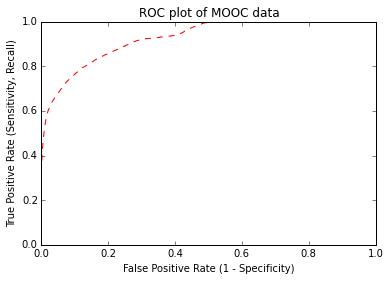

In [156]:
fpr, tpr, thresholds = skm.roc_curve(y_test, probabilities)
plt.plot(fpr, tpr, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of MOOC data")
plt.show()

In [157]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, model.predict(X_test))

array([[171489,   8721],
       [  3951,   8181]])

In [158]:
print classification_report(y_test, model.predict(X_test))

             precision    recall  f1-score   support

      False       0.98      0.95      0.96    180210
       True       0.48      0.67      0.56     12132

avg / total       0.95      0.93      0.94    192342

